1: Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Data Preprocessing

In [6]:
df = pd.read_csv(r'E:\projects\HumanCogntiveScore prediction\data\human_cognitive_performance.csv')

# One-hot encoding and cleanup
df = pd.get_dummies(df, columns=['Gender', 'Diet_Type', 'Exercise_Frequency'], drop_first=True)
df = df.drop(['User_ID', 'AI_Predicted_Score'], axis=1)

# Outlier Removal
df_cleaned = df.copy()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
df_cleaned.reset_index(drop=True, inplace=True)


In [7]:
X = df_cleaned.drop('Cognitive_Score', axis=1)
y = df_cleaned['Cognitive_Score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

# Scale features and targets
feature_scaler = RobustScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

target_scaler = RobustScaler()
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

x_train_scratch = X_train_scaled.T
y_train_scratch = np.array(y_train_scaled).reshape(1,-1)

x_test_scratch = X_test_scaled.T
y_test_scratch = np.array(y_test_scaled).reshape(1,-1)

# Data visualization

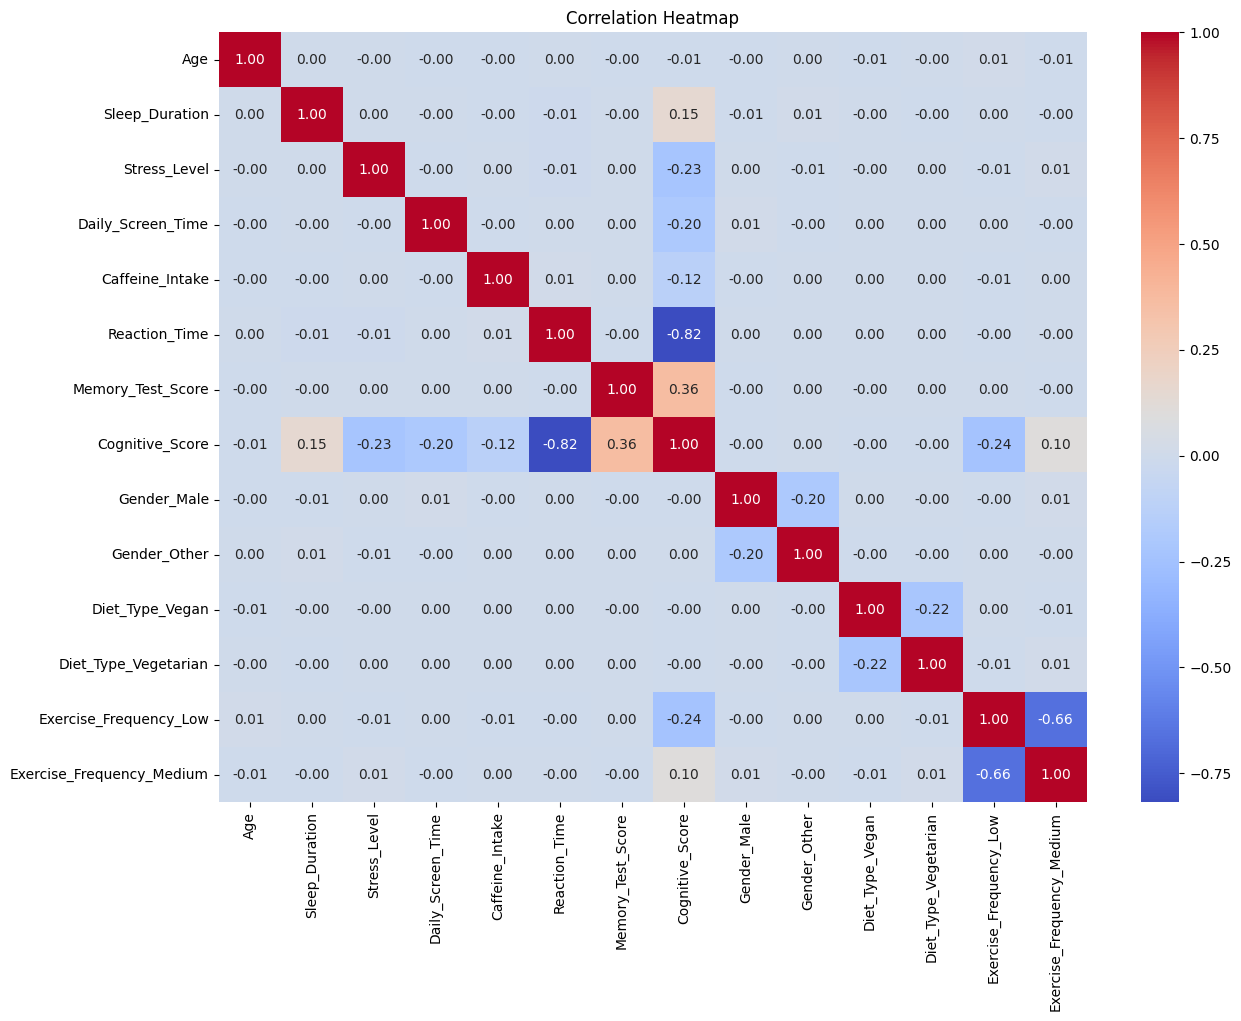

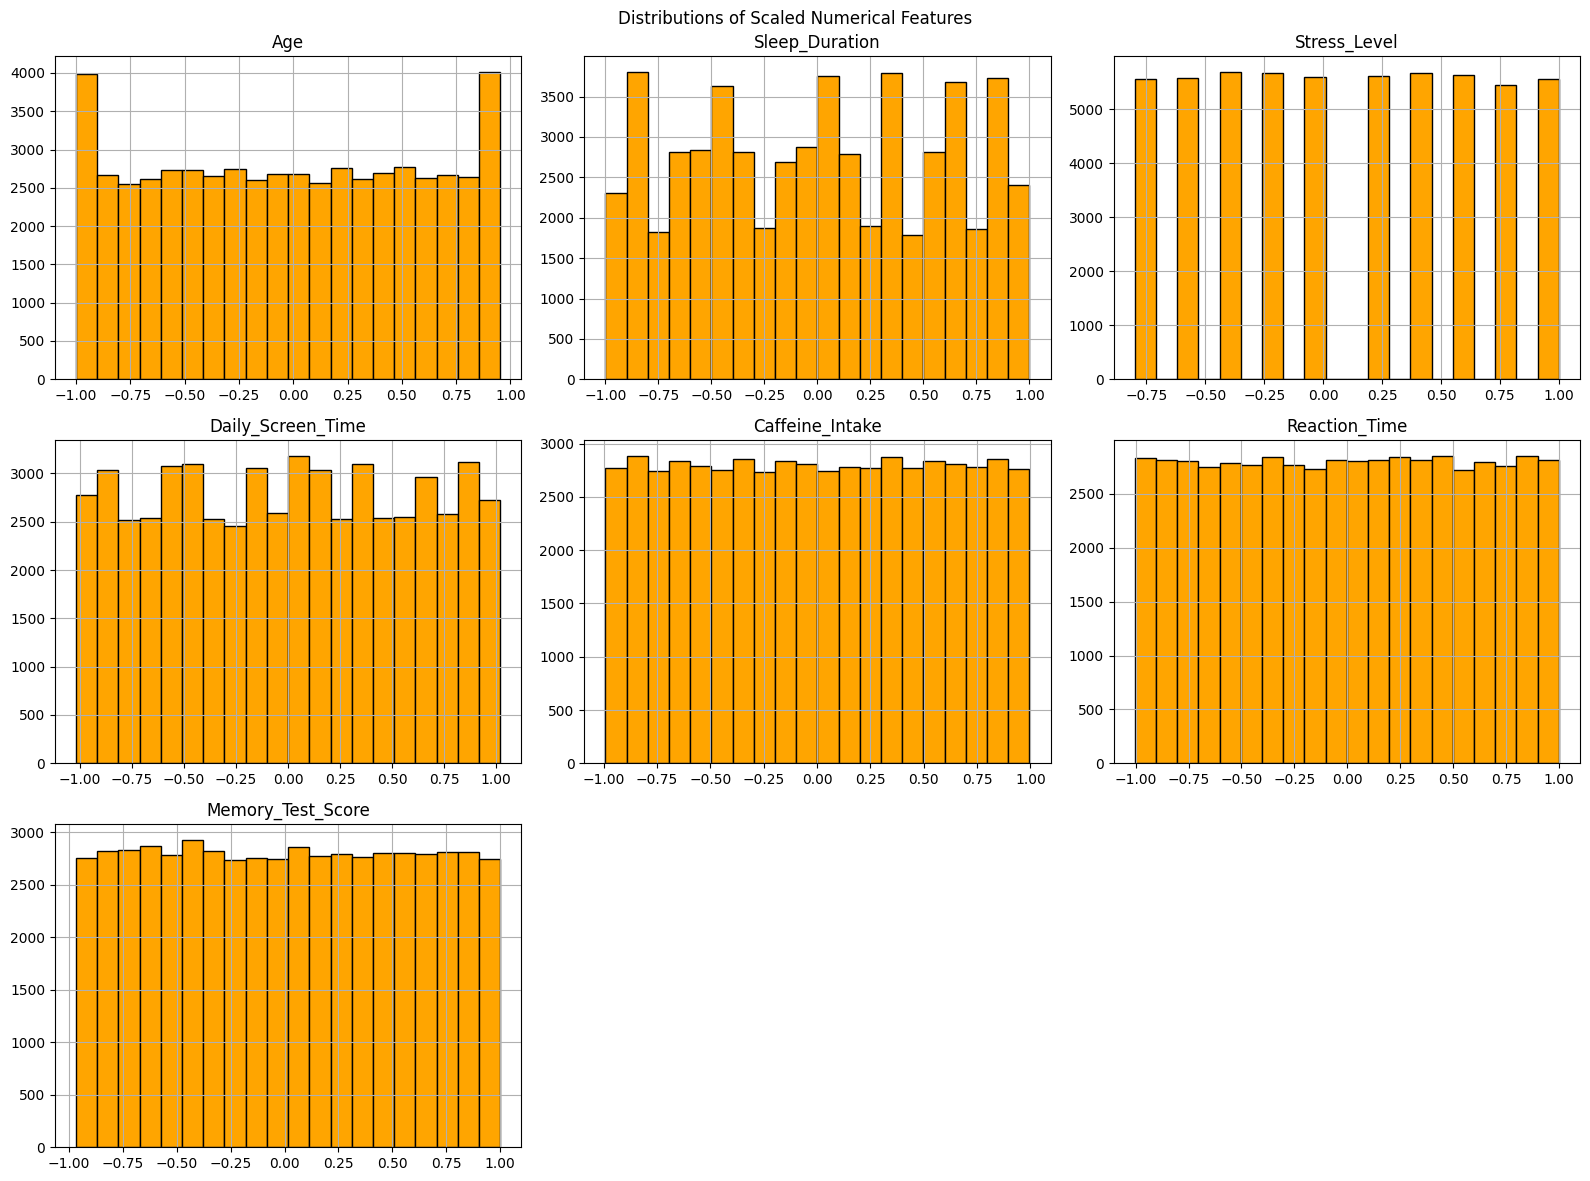

In [8]:
plt.figure(figsize=(14,10))
sns.heatmap(df_cleaned.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('plots/correlation_heatmap.png')
plt.show()

numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns

X_cleaned_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_cleaned_df[numeric_cols].hist(bins=20, figsize=(16, 12), color='orange', edgecolor='black')
plt.suptitle('Distributions of Scaled Numerical Features')
plt.tight_layout()
plt.savefig('plots/feature_distributions.png')
plt.show()


## FNN from scratch

The model is still under developement

In [9]:
import numpy as np

""" dimensional summary
        - X: n x m
        - y: 1 x m

"""

class MLP:
    def __init__(self, optimizer ,task_type, layers_dims, activations, learning_rate = 0.01, batch_size = 0):
        """
        Parameters:
        - optimizer: 'mini-batch', 'batch', >> in the future >> 'GD_w_momentum', 'RMSprop', 'adam'
        - task_type: "classification", "multi-class", or "regression"
        - layers_dims: list of layer dimensions (input, hidden..., output)
        - activations: list of activation functions for each layer (except input)
        - learning_rate: learning rate for gradient descent
        - random_seed: random seed for reproducibility
        """
        self.optimizer = optimizer
        self.task_type = task_type
        self.layers_dims = layers_dims
        self.activations = activations
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parameters = None
        self.costs = []
        
        assert (optimizer in ['mini-batch', 'batch'])
        assert (task_type in ['classification', 'regression'])
        assert (len(activations) == len(layers_dims)-1)
        
    
        
    def initialize_parameters(self):    #HE initialization for relu and regular for linear regression
        self.parameters = {}
        L = len(self.layers_dims)
        for l in range(1,L):    
            self.parameters['W'+str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l-1]) * np.sqrt(2/self.layers_dims[l-1])
            self.parameters['b'+str(l)] = np.zeros((self.layers_dims[l],1))

    
    def activation(self, z, astring):
        if astring == 'relu':
            return np.maximum(z, 0)
        elif astring == "sigmoid":
            return 1 / (1 +  np.exp(-z))
        elif astring == "tanh":
            return np.tanh(z)
        elif astring == "linear":
            return z
        elif astring == 'leaky_relu':
            return np.where(z > 0, z, 0.01*z)
        else:
            raise ValueError("Invalid activation type. Choose 'relu', 'sigmoid', 'tanh', 'leaky_relu' or 'linear'.")
        
    def activation_derivative(self, a, astring):
        """Compute derivative of activation function."""
        if astring == "relu":
            return np.where(a > 0, 1, 0)
        elif astring == "sigmoid":
            sig = 1 / (1 + np.exp(-a))  
            return sig * (1 - sig)
        elif astring == "tanh":
            return 1 - np.tanh(a) ** 2
        elif astring == "linear":
            return 1
        elif astring == "leaky_relu":
            return np.where(a > 0, 1, 0.01)
        else:
            raise ValueError("Invalid activation type. Choose 'relu', 'sigmoid', 'tanh', 'leaky_relu', or 'linear'.")
        
        
    def compute_cost(self, AL, Y, epsilon=1e-10):
        if self.task_type == "classification" or self.task_type == 'multi-class':
            AL = np.clip(AL, epsilon, 1-epsilon)
            
        
        if self.task_type == "classification":
            cost = -np.mean(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
            
        elif self.task_type == "multi-class":
            cost = -np.mean(Y * np.log(AL))
        
        elif self.task_type == "regression":
            cost = np.mean((AL - Y)**2)
        
        else:
            raise ValueError("Invalid task_type. Choose 'classification', 'multi-class', or 'regression'.")
        
        return cost
    
    def cost_derivative(self, AL, Y, epsilon=1e-10):
        """Compute derivative of the cost function."""
        if self.task_type == "classification" or self.task_type == 'multi-class':
            AL = np.clip(AL, epsilon, 1-epsilon)
        
        if self.task_type == "classification":
            dAL = -(Y / AL - (1 - Y) / (1 - AL))
            
        elif self.task_type == "multi-class":
            dAL = -Y / AL
        
        elif self.task_type == "regression":
            dAL = 2 * (AL - Y)
        
        else:
            raise ValueError("Invalid task_type. Choose 'classification', 'multi-class', or 'regression'.")
        
        return dAL
    
    def forward_propagation(self, X):
        """Perform forward propagation."""
        caches = {'A0': X}
        A = X
        L = len(self.parameters) // 2
        
        for l in range(1, L+1):
            W, b = self.parameters[f"W{l}"], self.parameters[f"b{l}"]

            Z = np.dot(W, A) + b
            
            A = self.activation(Z, self.activations[l-1])
            
            caches[f"Z{l}"], caches[f"A{l}"] = Z, A
            
        return A, caches
    
    def back_propagation(self, AL, Y, caches):
        """Perform backpropagation."""
        m = Y.shape[1]
        grads = {}
        L = len(self.activations)
        
        dAL = self.cost_derivative(AL, Y)
        dZL = dAL * self.activation_derivative(caches[f"Z{L}"], self.activations[L-1])
        
        grads[f"dW{L}"] = (1.0/m) * np.dot(dZL, caches[f"A{L-1}"].T).astype(np.float64)
        grads[f"db{L}"] = (1.0/m) * np.sum(dZL, axis=1, keepdims=True).astype(np.float64)
        
        dA_prev = np.dot(self.parameters[f"W{L}"].T, dZL)
        
        for l in range(L-1, 0, -1):
            dZL = dA_prev * self.activation_derivative(caches[f"Z{l}"], self.activations[l-1])
            grads[f"dW{l}"] = (1.0/m) * np.dot(dZL, caches[f"A{l-1}"].T).astype(np.float64)
            grads[f"db{l}"] = (1.0/m) * np.sum(dZL, axis=1, keepdims=True).astype(np.float64)
            dA_prev = np.dot(self.parameters[f"W{l}"].T, dZL)
            
        return grads
    
    def update_parameters(self, grads):
        """Update parameters using gradient descent."""
        L = len(self.parameters) // 2
        
        for l in range(1, L+1):
            self.parameters[f"W{l}"] -= self.learning_rate * grads[f"dW{l}"]
            self.parameters[f"b{l}"] -= self.learning_rate * grads[f"db{l}"]
    
    def train(self, X, Y, epochs=10000, print_interval=100):
        """Train the neural network."""
        self.initialize_parameters()
        if self.optimizer == 'mini-batch':
                return None # for future implementation
                            
        elif self.optimizer == 'batch':
            for epoch in range(epochs):
                AL, caches = self.forward_propagation(X)
                
                assert (AL.shape == Y.shape)
                
                cost = self.compute_cost(AL, Y)
                self.costs.append(cost)
                
                grads = self.back_propagation(AL, Y, caches)
                self.update_parameters(grads)
                
                if print_interval and epoch % print_interval == 0:
                    print(f"Epoch {epoch}: Cost = {cost}")                    
            return self
    
    def predict(self, X):
        """Make predictions."""
        AL, _ = self.forward_propagation(X)
        
        if self.task_type == "classification":
            return (AL > 0.5).astype(int)
        elif self.task_type == "multi-class":
            return np.argmax(AL, axis=0)
        elif self.task_type == "regression":
            return AL
        else:
            raise ValueError("Invalid task_type. Choose 'classification', 'multi-class', or 'regression'.")
        
    def evaluate(self, X, Y):
        predictions = self.predict(X)
        if self.task_type == "regression":
            u = np.sum((Y - predictions)**2)
            v = np.sum((Y - np.mean(Y))**2)
            r2 = 1 - u/v
            return r2
        elif self.task_type == "classification":
            return np.mean(predictions == Y)
        
        
    def LRdecay(self, epoch, decay_rate):
        self.learning_rate *= 1/(epoch*decay_rate)
    
    


In [10]:

input_features = x_train_scratch.shape[0]
layers_dims = [input_features, 32, 16, 1]
activ_fn = ['relu', 'relu', 'linear']

scratch_model = MLP('batch', 'regression', layers_dims, activ_fn)

scratch_model.train(x_train_scratch,y_train_scratch, epochs=1000, print_interval=100)

r2_scratch = scratch_model.evaluate(x_test_scratch, y_test_scratch)
y_pred_scratch = scratch_model.predict(x_test_scratch)


Epoch 0: Cost = 0.8003718838049112
Epoch 100: Cost = 0.2723870840844575
Epoch 200: Cost = 0.16741449417686868
Epoch 300: Cost = 0.12093384128825517
Epoch 400: Cost = 0.09561086584463603
Epoch 500: Cost = 0.07913487756072085
Epoch 600: Cost = 0.06738769341722183
Epoch 700: Cost = 0.058597600024334576
Epoch 800: Cost = 0.05177264568835988
Epoch 900: Cost = 0.04633602574049953


## FNN model using tensorflow

In [11]:
tf_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    BatchNormalization(),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    
    Dense(1)
])

tf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)

history = tf_model.fit(X_train_scaled, y_train_scaled, 
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=25,
                    batch_size=128,
                    callbacks=[reduce_lr])

y_pred_tf = tf_model.predict(X_test_scaled)
y_pred_tf = target_scaler.inverse_transform(y_pred_tf)


Epoch 1/25


c:\Users\abdal\miniconda3\envs\BedoEnv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1906 - mse: 0.1906 - val_loss: 0.0570 - val_mse: 0.0570 - learning_rate: 0.0010
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0204 - val_mse: 0.0204 - learning_rate: 0.0010
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0217 - val_mse: 0.0217 - learning_rate: 0.0010
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0138 - val_mse: 0.0138 - learning_rate: 0.0010
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0139 - val_mse: 0.0139 - learning_rate: 0.0010
Epoch 6/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0215 - val_mse: 0.0215 - learning_rate: 0.0010
Epoch 7/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0183 - val_mse: 0.0183 - learning_rate: 0.0010
Epoch 8/25
438/43

## Simple LinearRegression model

In [12]:
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, y_train_scaled)

y_pred_lr = target_scaler.inverse_transform(lr_model.predict(X_test_scaled).reshape(-1, 1))

# Performance comparison between the models

In [13]:
y_pred_scratch = y_pred_scratch.flatten().reshape(-1, 1)
y_pred_scratch_inv = target_scaler.inverse_transform(y_pred_scratch)
y_pred_tf = y_pred_tf.flatten()
y_pred_lr = y_pred_lr.flatten()

results = {
    "Model": ["Linear Regression", "TensorFlow FNN", "Scratch FNN"],
    "MAE": [mean_absolute_error(y_test, y_pred_lr), mean_absolute_error(y_test, y_pred_tf), mean_absolute_error(y_test, y_pred_scratch_inv)],
    "RMSE": [np.sqrt(mean_squared_error(y_test, y_pred_lr)), np.sqrt(mean_squared_error(y_test, y_pred_tf)), np.sqrt(mean_squared_error(y_test, y_pred_scratch_inv))],
    "R²": [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_tf), r2_scratch]
}

results_df = pd.DataFrame(results)
print(results_df)

               Model       MAE      RMSE        R²
0  Linear Regression  0.627877  1.527359  0.995556
1     TensorFlow FNN  4.898789  6.051325  0.930239
2        Scratch FNN  5.707344  7.219578  0.900703


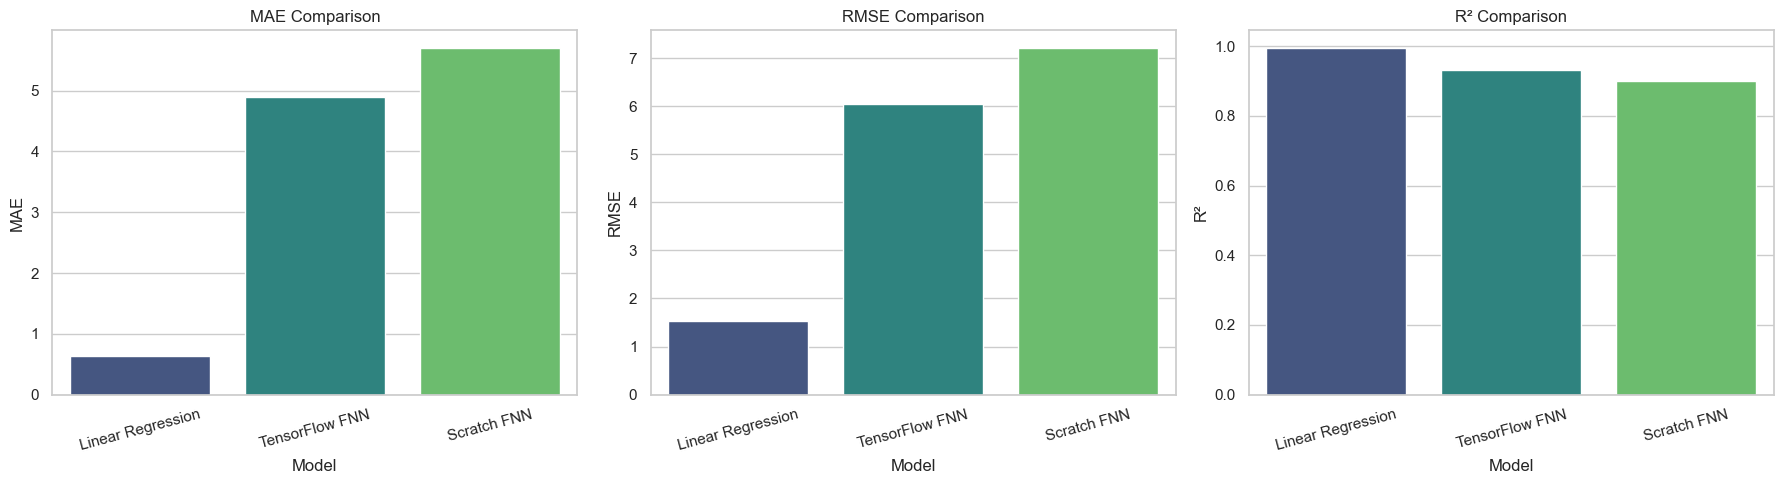

In [14]:
# Melt the DataFrame to long format
results_long = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set style
sns.set(style='whitegrid')

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['MAE', 'RMSE', 'R²']
palette = sns.color_palette('viridis', n_colors=3)

for i, metric in enumerate(metrics):
    metric_data = results_long[results_long['Metric'] == metric]
    sns.barplot(data=metric_data, x='Model', y='Score', hue='Model', ax=axes[i], palette=palette, legend=False)
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('plots/metric_comparison.png')
plt.show()
